# `YPlusModel` Tutorial

Trey V. Wenger (c) August 2024

Here we demonstrate the basic features of the `YPlusModel` model. The `YPlusModel` models the radio recombiation line emission to infer `y+`, the helium abundance by number.

In [1]:
# General imports
from IPython.display import display, Image
    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_yplus
print("bayes_yplus version:", bayes_yplus.__version__)

from bayes_yplus import YPlusModel

# Notebook configuration
pd.options.display.max_rows = None

# plot directory and extension
figdir = "figures"
ext = "png"
if not os.path.isdir(figdir):
    os.mkdir(figdir)
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.4.3+2.g5ecf2cc
bayes_yplus version: 0+untagged.1.g9da35d3.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `YPlusModel`, but we must pack a "dummy" data structure first. The model expects the observation to be named `"observation"`.

Text(0, 0.5, 'Brightness Temperature (mK)')

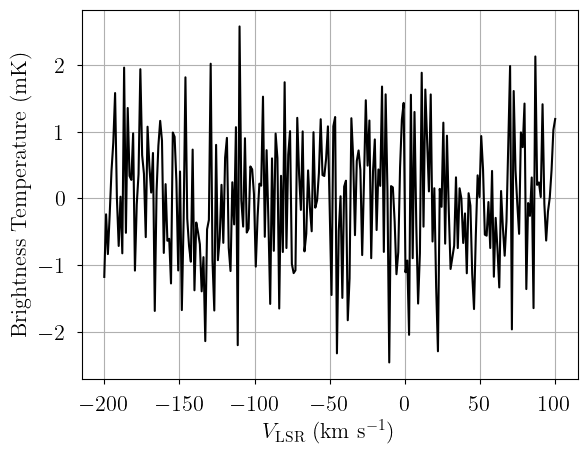

In [2]:
from bayes_spec import SpecData

# spectral axis definition
spec_axis = np.linspace(-200.0, 100.0, 251) # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # mK

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(spec_axis)) # mK

# HFSModel only expects a single observation named "observation"
observation = SpecData(
    spec_axis,
    brightness_data,
    noise,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel="Brightness Temperature (mK)",
)
dummy_data = {"observation": observation}

# Plot the dummy data
plt.plot(dummy_data["observation"].spectral, dummy_data["observation"].brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood for a given set of model parameters.

Text(0, 0.5, 'Brightness Temperature (mK)')

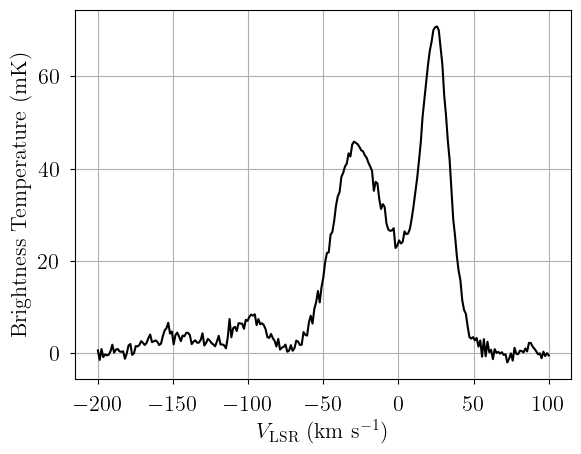

In [3]:
# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = YPlusModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_H_area = 1000.0, # mode of H_area prior (mK km s-1)
    prior_H_center = [0.0, 25.0], # H_center prior (km s-1)
    prior_H_fwhm = 20.0, # H FWHM line width prior (km s-1)
    prior_He_H_fwhm_ratio = 0.1, # He/H FWHM ratio prior
    prior_yplus = 0.1, # mode of yplus prior
    prior_rms = 1.0, # width of spectral rms prior (mK)
)
model.add_likelihood()

sim_brightness = model.model.observation.eval({
    "H_area": [1500.0, 1000.0, 1250.0],
    "H_center": [-30.0, 5.0, 25.0],
    "H_fwhm": [35.0, 50.0, 20.0],
    "He_H_fwhm_ratio": [1.0, 0.8, 1.25],
    "yplus": [0.1, 0.05, 0.15],
    "rms_observation": noise,
    "observation_baseline_norm": [0.0, -0.05, 0.01], # normalized baseline coefficients
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    spec_axis,
    sim_brightness,
    noise,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel="Brightness Temperature (mK)",
)
data = {"observation": observation}

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `YPlusModel`. Here we create a new model with the simulated data.

In [5]:
# Initialize and define the model
model = YPlusModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_H_area = 1000.0, # mode of H_area prior (mK km s-1)
    prior_H_center = [0.0, 25.0], # H_center prior (km s-1)
    prior_H_fwhm = 20.0, # H FWHM line width prior (km s-1)
    prior_He_H_fwhm_ratio = 0.1, # He/H FWHM ratio prior
    prior_yplus = 0.1, # mode of yplus prior
    prior_rms = 1.0, # width of spectral rms prior (mK)
)
model.add_likelihood()

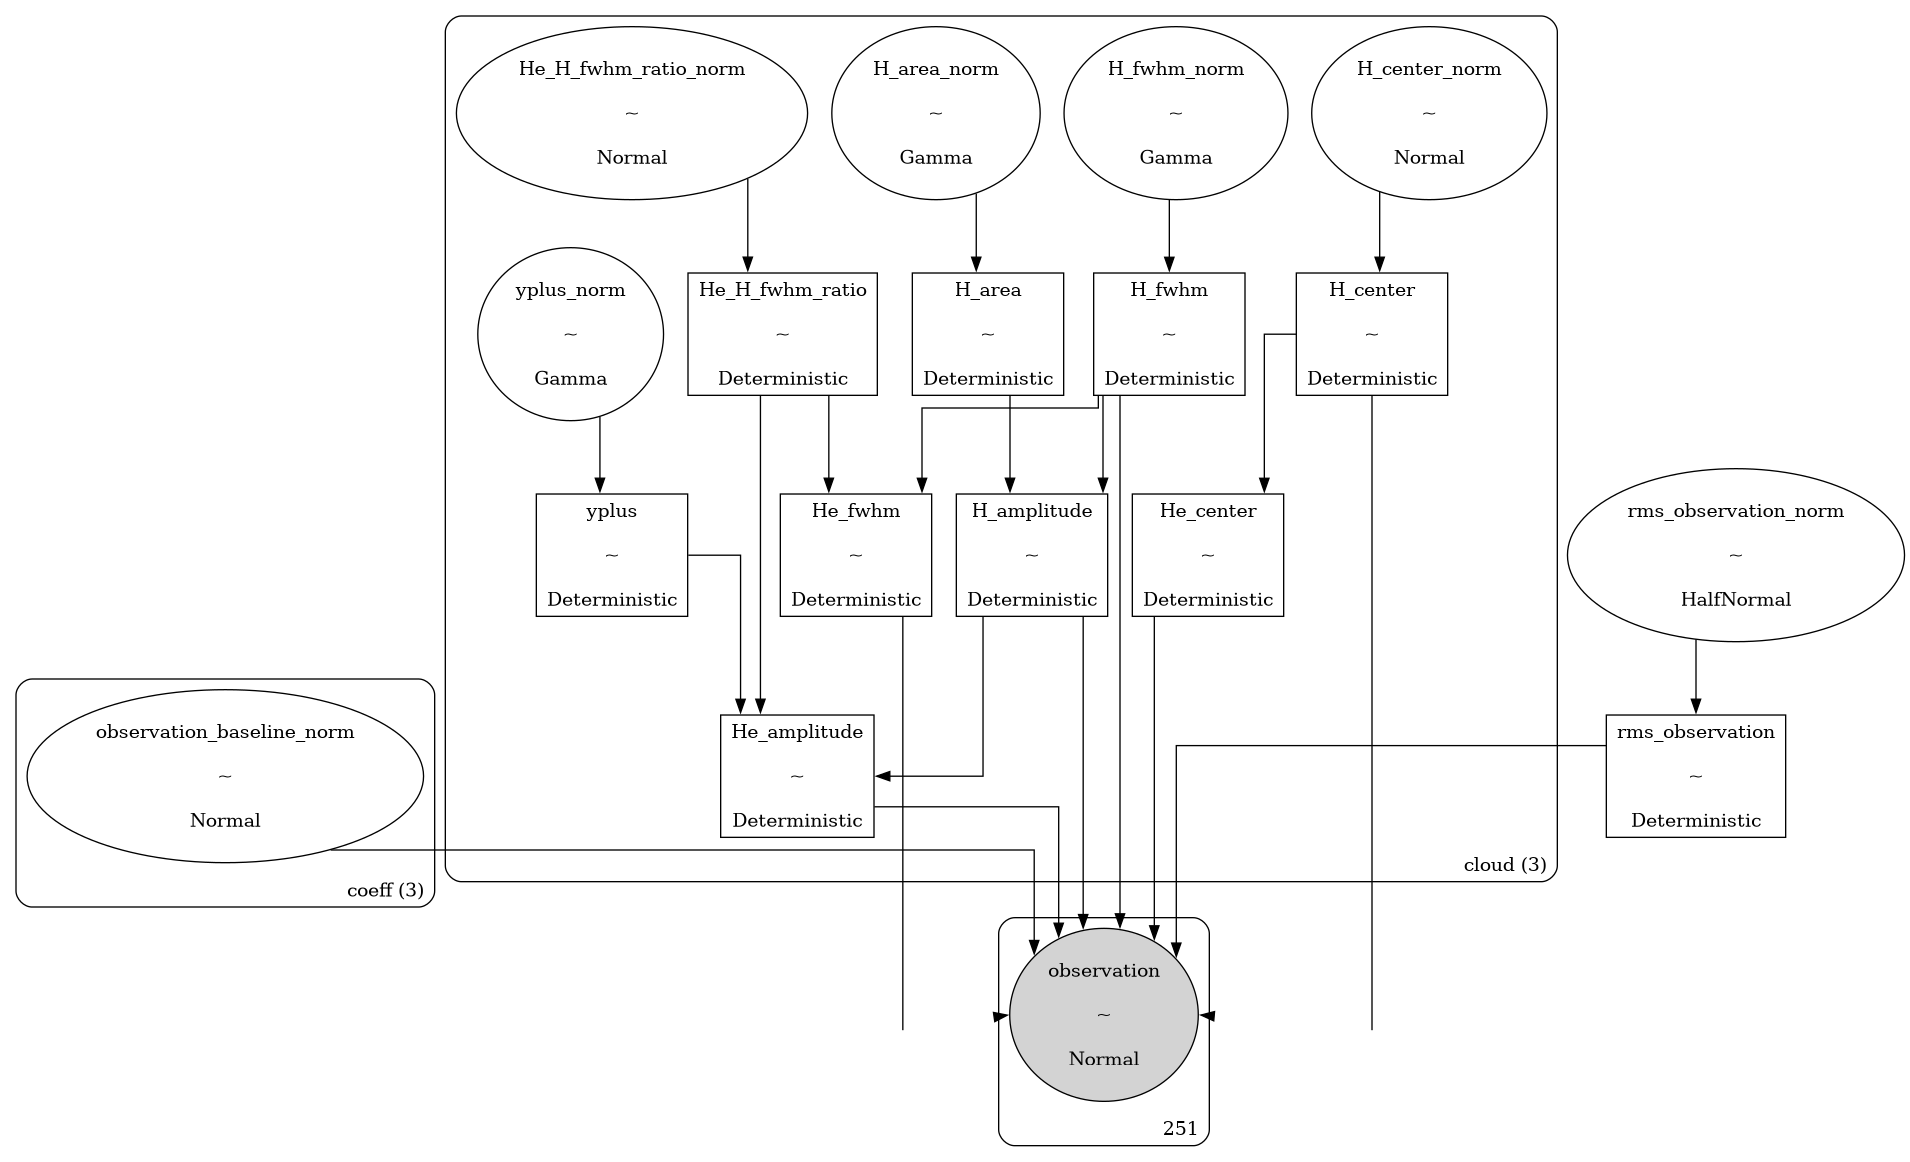

In [6]:
# Plot model graph
model.plot_graph(f"{figdir}/model.gv", ext)
Image(f"{figdir}/model.gv.{ext}")

In [7]:
# model string representation
print(model.model.str_repr())

observation_baseline_norm ~ Normal(0, 1)
              H_area_norm ~ Gamma(2, f())
            H_center_norm ~ Normal(0, 1)
              H_fwhm_norm ~ Gamma(3, f())
     He_H_fwhm_ratio_norm ~ Normal(0, 1)
               yplus_norm ~ Gamma(3, f())
     rms_observation_norm ~ HalfNormal(0, 1)
                   H_area ~ Deterministic(f(H_area_norm))
                 H_center ~ Deterministic(f(H_center_norm))
                   H_fwhm ~ Deterministic(f(H_fwhm_norm))
          He_H_fwhm_ratio ~ Deterministic(f(He_H_fwhm_ratio_norm))
                    yplus ~ Deterministic(f(yplus_norm))
          rms_observation ~ Deterministic(f(rms_observation_norm))
              H_amplitude ~ Deterministic(f(H_fwhm_norm, H_area_norm))
             He_amplitude ~ Deterministic(f(He_H_fwhm_ratio_norm, yplus_norm, H_fwhm_norm, H_area_norm))
                He_center ~ Deterministic(f(H_center_norm))
                  He_fwhm ~ Deterministic(f(H_fwhm_norm, He_H_fwhm_ratio_norm))
              observati

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [H_area_norm, H_center_norm, H_fwhm_norm, He_H_fwhm_ratio_norm, observation, observation_baseline_norm, rms_observation_norm, yplus_norm]


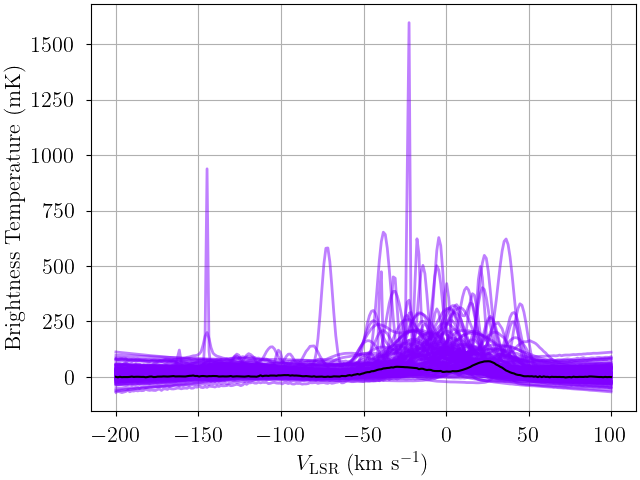

In [8]:
# prior predictive check
prior = model.prior_predictive_check(
    samples=100,  # prior predictive samples
    plot_fname=f"{figdir}/prior_predictive.{ext}",
)
Image(f"{figdir}/prior_predictive.{ext}")

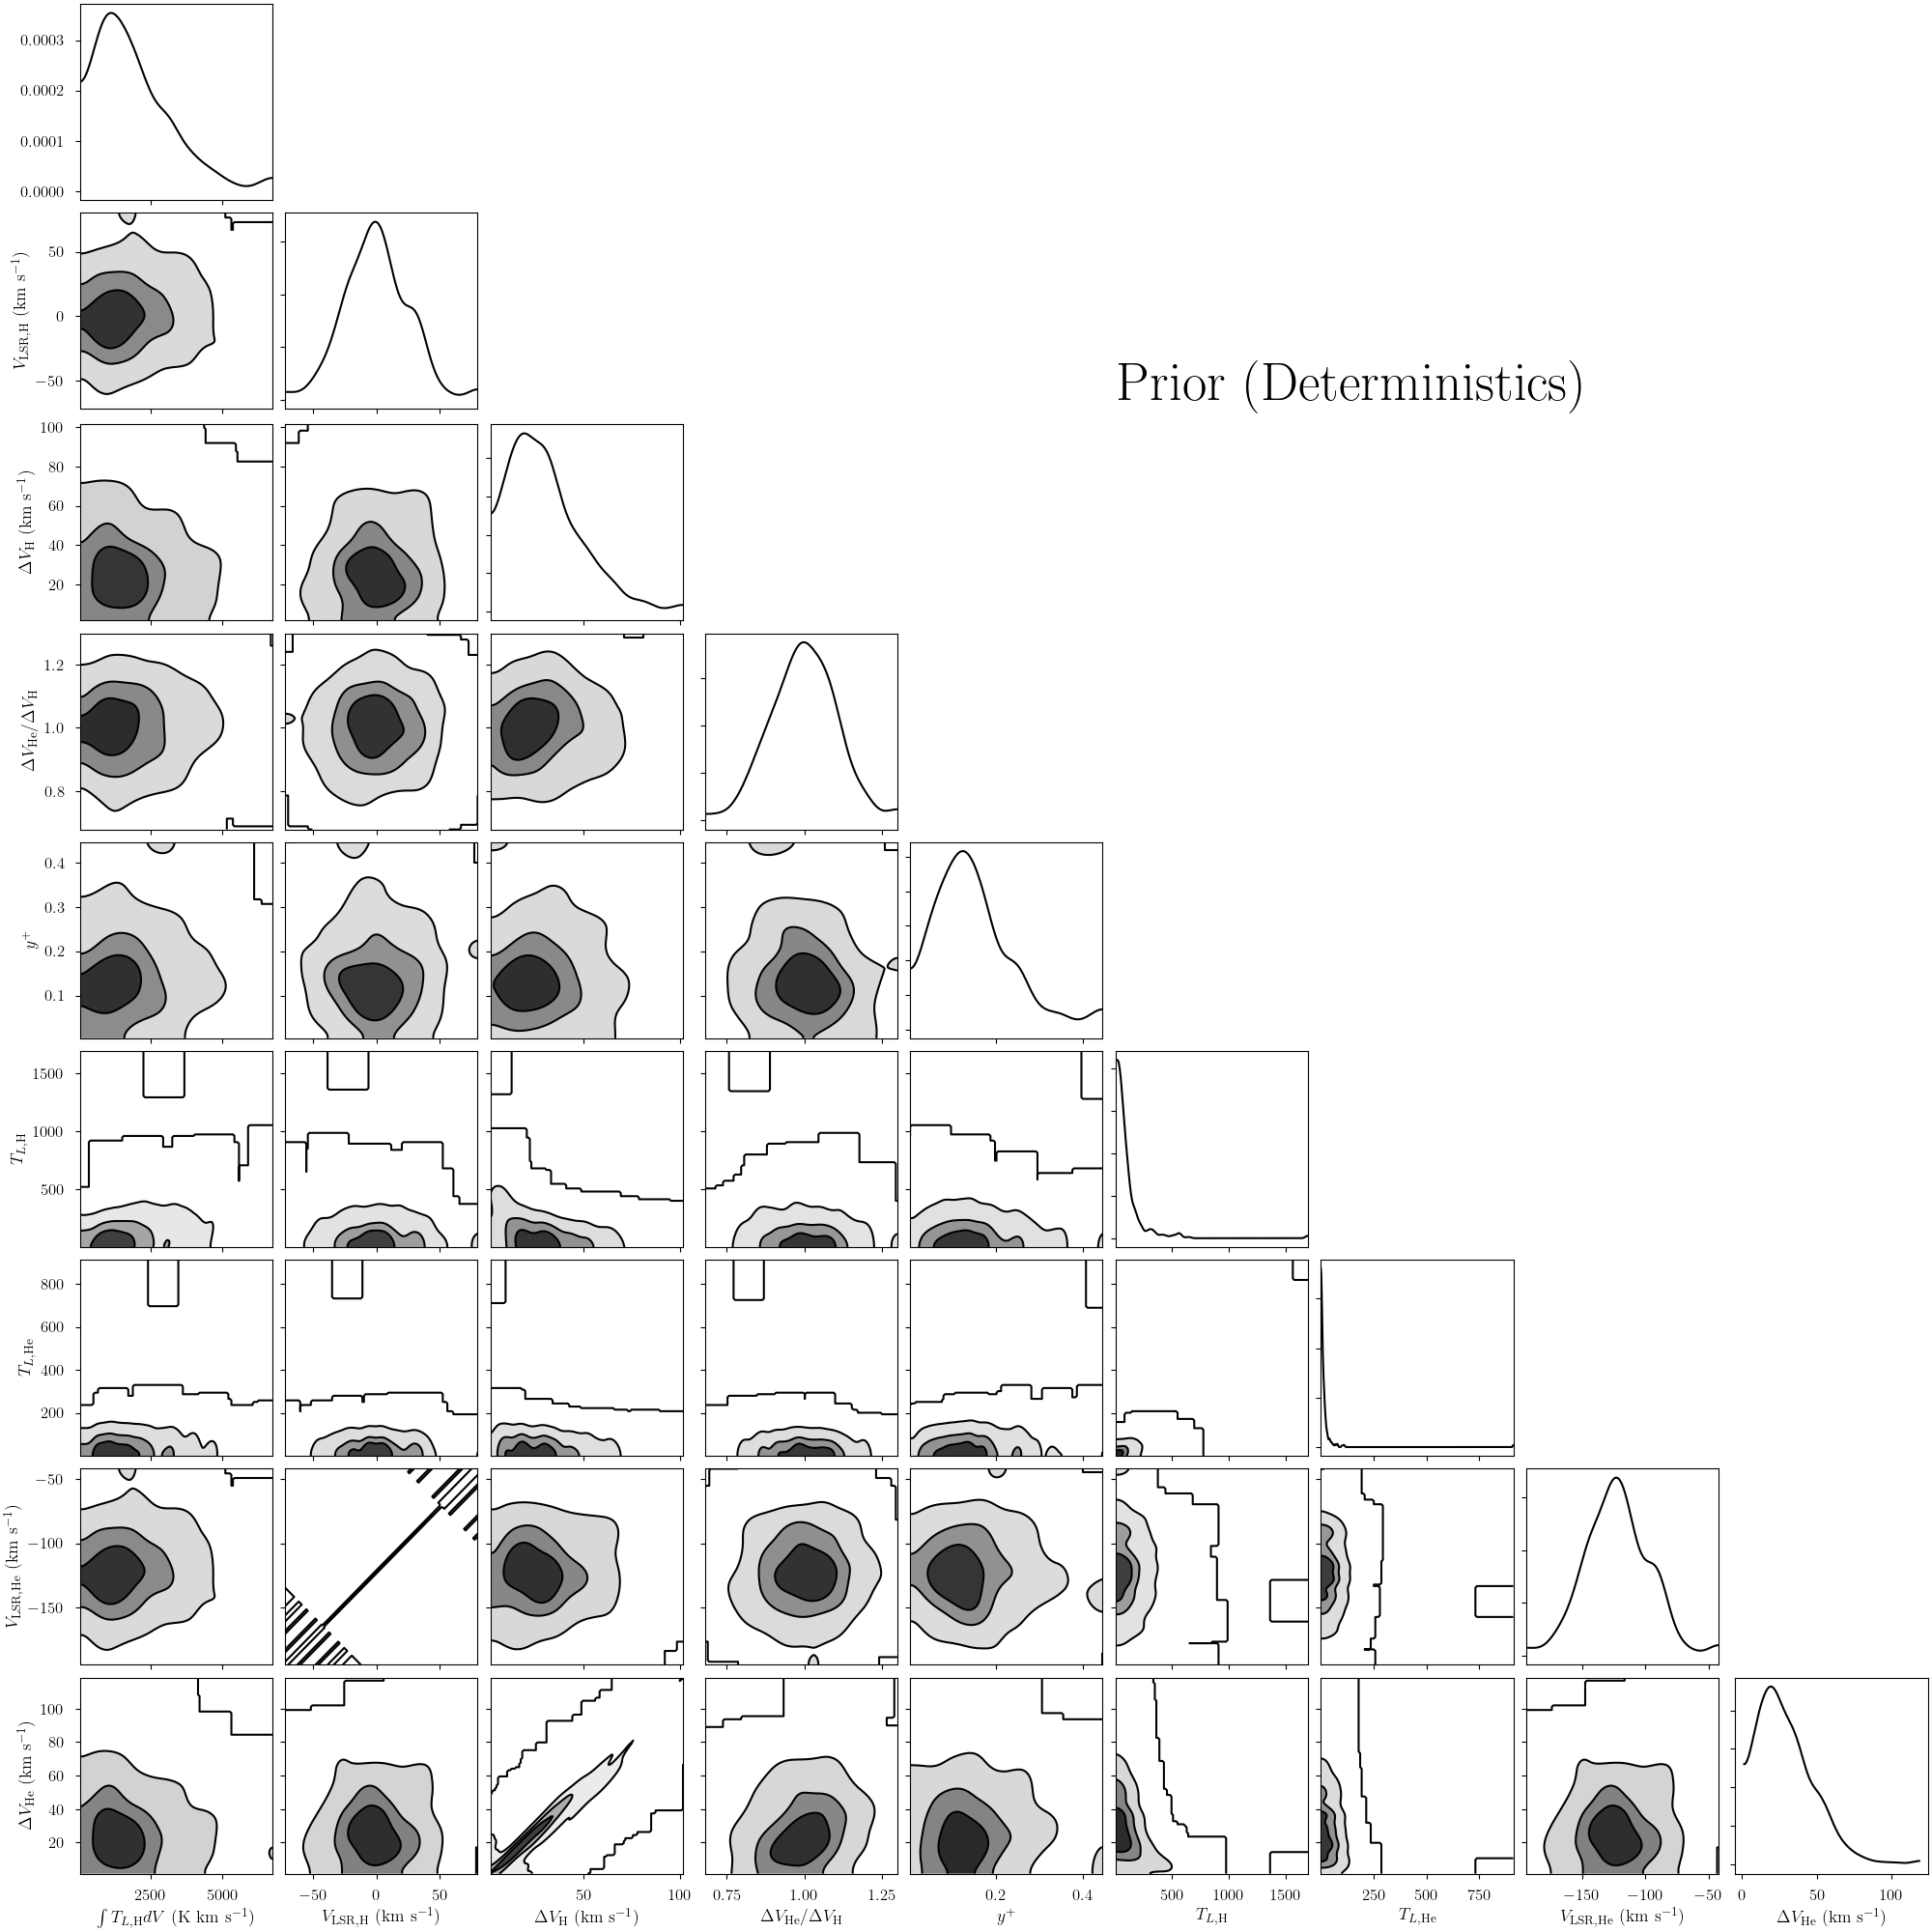

In [9]:
from bayes_spec.plots import plot_pair

var_names = [param for param in model.deterministics if param != "rms_observation"]
plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    "Prior (Deterministics)", # plot label
    f"{figdir}/pair_prior_determ.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
Image(f"{figdir}/pair_prior_determ.{ext}")

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 3700
Interrupted at 3,699 [3%]: Average Loss = 18,369


Runtime: 0.13 minutes


In [11]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [12]:
pm.summary(model.trace.solution_0, var_names=model.deterministics)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
H_area[0],1336.403,11.294,1314.844,1356.242,0.392,0.277,831.0,942.0,NaN
H_area[1],1070.963,15.204,1042.620,1098.247,0.507,0.359,895.0,703.0,NaN
H_area[2],1317.161,8.906,1301.219,1333.964,0.289,0.205,950.0,874.0,NaN
H_center[0],-30.618,0.144,-30.891,-30.354,0.004,0.003,1036.0,915.0,NaN
H_center[1],0.013,0.448,-0.781,0.846,0.014,0.010,1051.0,850.0,NaN
H_center[2],24.955,0.077,24.827,25.103,0.002,0.002,1050.0,1025.0,NaN
H_fwhm[0],33.955,0.319,33.424,34.579,0.010,0.007,1005.0,908.0,NaN
H_fwhm[1],52.250,0.778,50.798,53.673,0.026,0.018,913.0,914.0,NaN
H_fwhm[2],20.462,0.138,20.189,20.698,0.004,0.003,1065.0,768.0,NaN
He_H_fwhm_ratio[0],0.985,0.071,0.854,1.113,0.002,0.002,997.0,885.0,NaN


Sampling: [observation]


Output()

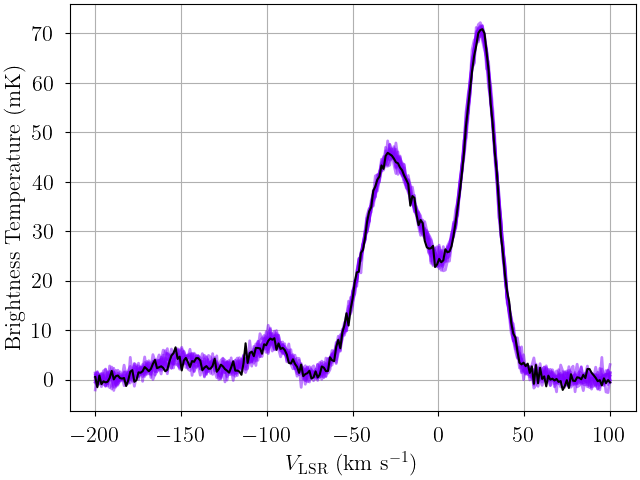

In [13]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive_vi.{ext}"
)
Image(f"{figdir}/posterior_predictive_vi.{ext}")

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [14]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3700
Interrupted at 3,699 [3%]: Average Loss = 18,369
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, H_area_norm, H_center_norm, H_fwhm_norm, He_H_fwhm_ratio_norm, yplus_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 97 seconds.


Runtime: 1.94 minutes


In [15]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [16]:
pm.summary(model.trace.solution_0, var_names=model.deterministics)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
H_area[0],1464.668,218.942,1030.672,1787.057,9.232,6.531,592.0,1139.0,1.01
H_area[1],1081.918,194.005,837.401,1486.693,8.032,5.717,705.0,830.0,1.00
H_area[2],1241.859,67.769,1115.124,1359.940,2.521,1.788,727.0,1699.0,1.01
H_center[0],-29.979,0.852,-31.378,-28.501,0.033,0.024,689.0,1930.0,1.00
H_center[1],4.397,6.333,-7.683,14.216,0.267,0.189,589.0,1111.0,1.01
H_center[2],25.029,0.111,24.838,25.246,0.004,0.003,994.0,2168.0,1.00
H_fwhm[0],34.964,1.536,32.030,37.685,0.061,0.043,658.0,1482.0,1.01
H_fwhm[1],51.114,6.371,40.649,63.146,0.266,0.190,609.0,852.0,1.01
H_fwhm[2],20.080,0.419,19.282,20.814,0.014,0.010,850.0,1957.0,1.00
He_H_fwhm_ratio[0],1.006,0.081,0.853,1.151,0.002,0.001,2588.0,2792.0,1.00


In [17]:
print("solutions:", model.solutions)
display(az.summary(model.trace["solution_0"]))
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
H_amplitude[0],39.175,4.345,30.727,45.137,0.185,0.131,582.0,996.0,1.01
H_amplitude[1],19.798,1.398,17.587,22.619,0.046,0.033,1086.0,1020.0,1.00
H_amplitude[2],58.062,2.083,54.071,61.498,0.077,0.055,723.0,1716.0,1.01
H_area[0],1464.668,218.942,1030.672,1787.057,9.232,6.531,592.0,1139.0,1.01
H_area[1],1081.918,194.005,837.401,1486.693,8.032,5.717,705.0,830.0,1.00
H_area[2],1241.859,67.769,1115.124,1359.940,2.521,1.788,727.0,1699.0,1.01
H_area_norm[0],1.465,0.219,1.031,1.787,0.009,0.007,592.0,1139.0,1.01
H_area_norm[1],1.082,0.194,0.837,1.487,0.008,0.006,705.0,830.0,1.00
H_area_norm[2],1.242,0.068,1.115,1.360,0.003,0.002,727.0,1699.0,1.01
H_center[0],-29.979,0.852,-31.378,-28.501,0.033,0.024,689.0,1930.0,1.00


We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [observation]


Output()

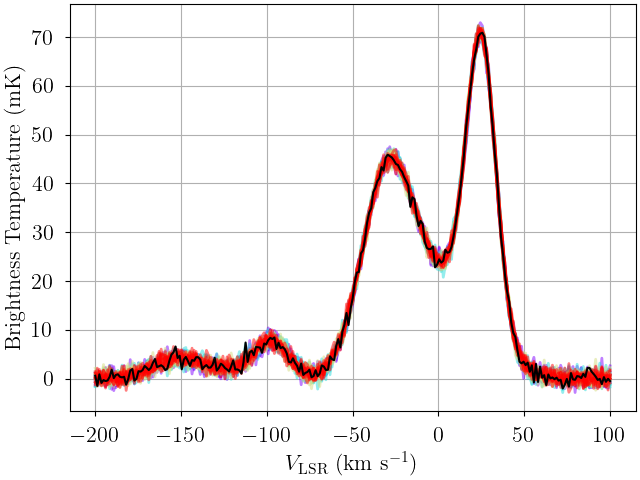

In [18]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive.{ext}"
)
Image(f"{figdir}/posterior_predictive.{ext}")

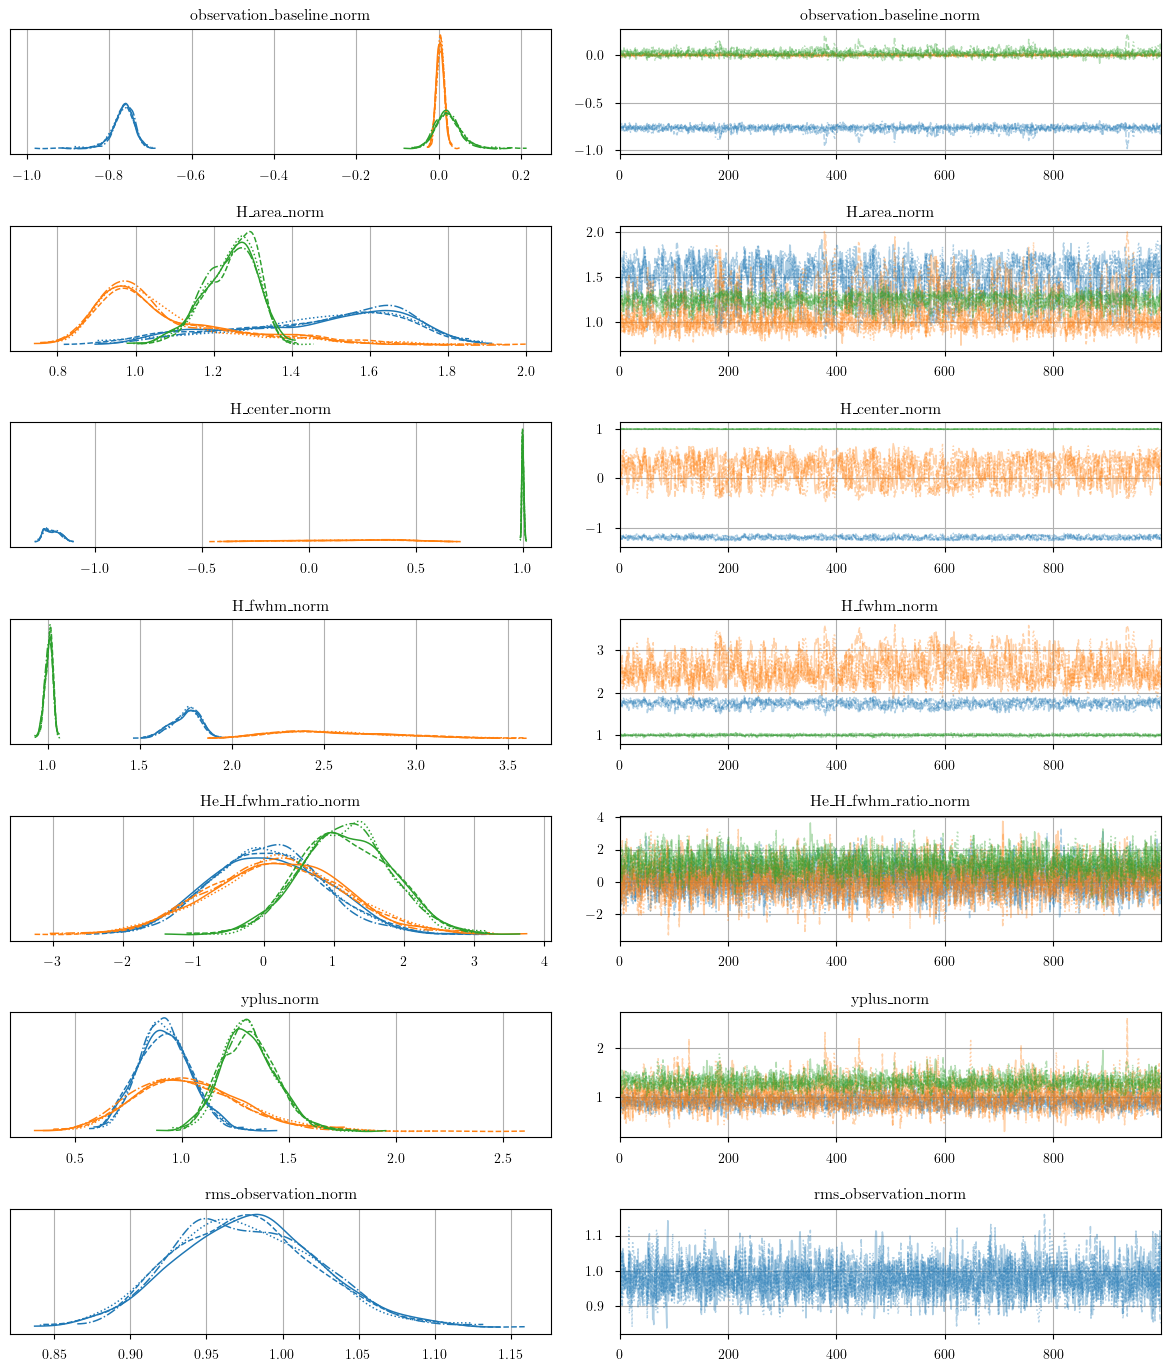

In [19]:
model.plot_traces(f"{figdir}/traces.{ext}")
Image(f"{figdir}/traces.{ext}")

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

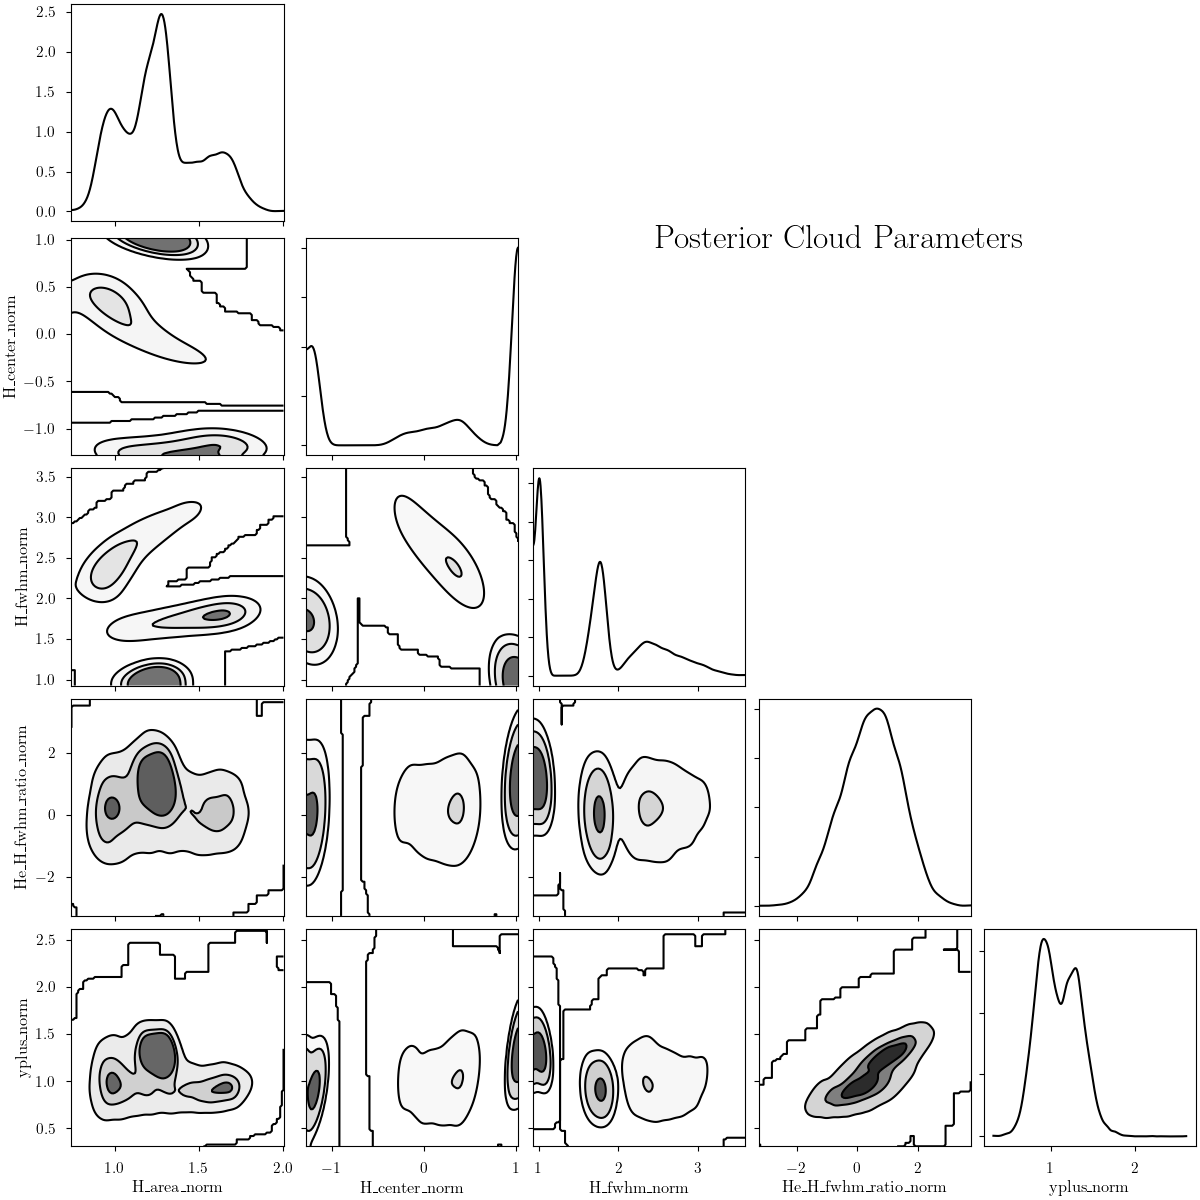

In [20]:
from bayes_spec.plots import plot_pair

plot_pair(
    model.trace, # samples
    model.cloud_params, # var_names to plot
    "Posterior Cloud Parameters", # plot label
    f"{figdir}/pair_posterior_cloud_params.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
Image(f"{figdir}/pair_posterior_cloud_params.{ext}")

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud (excluding the spectral rms hyper parameter).

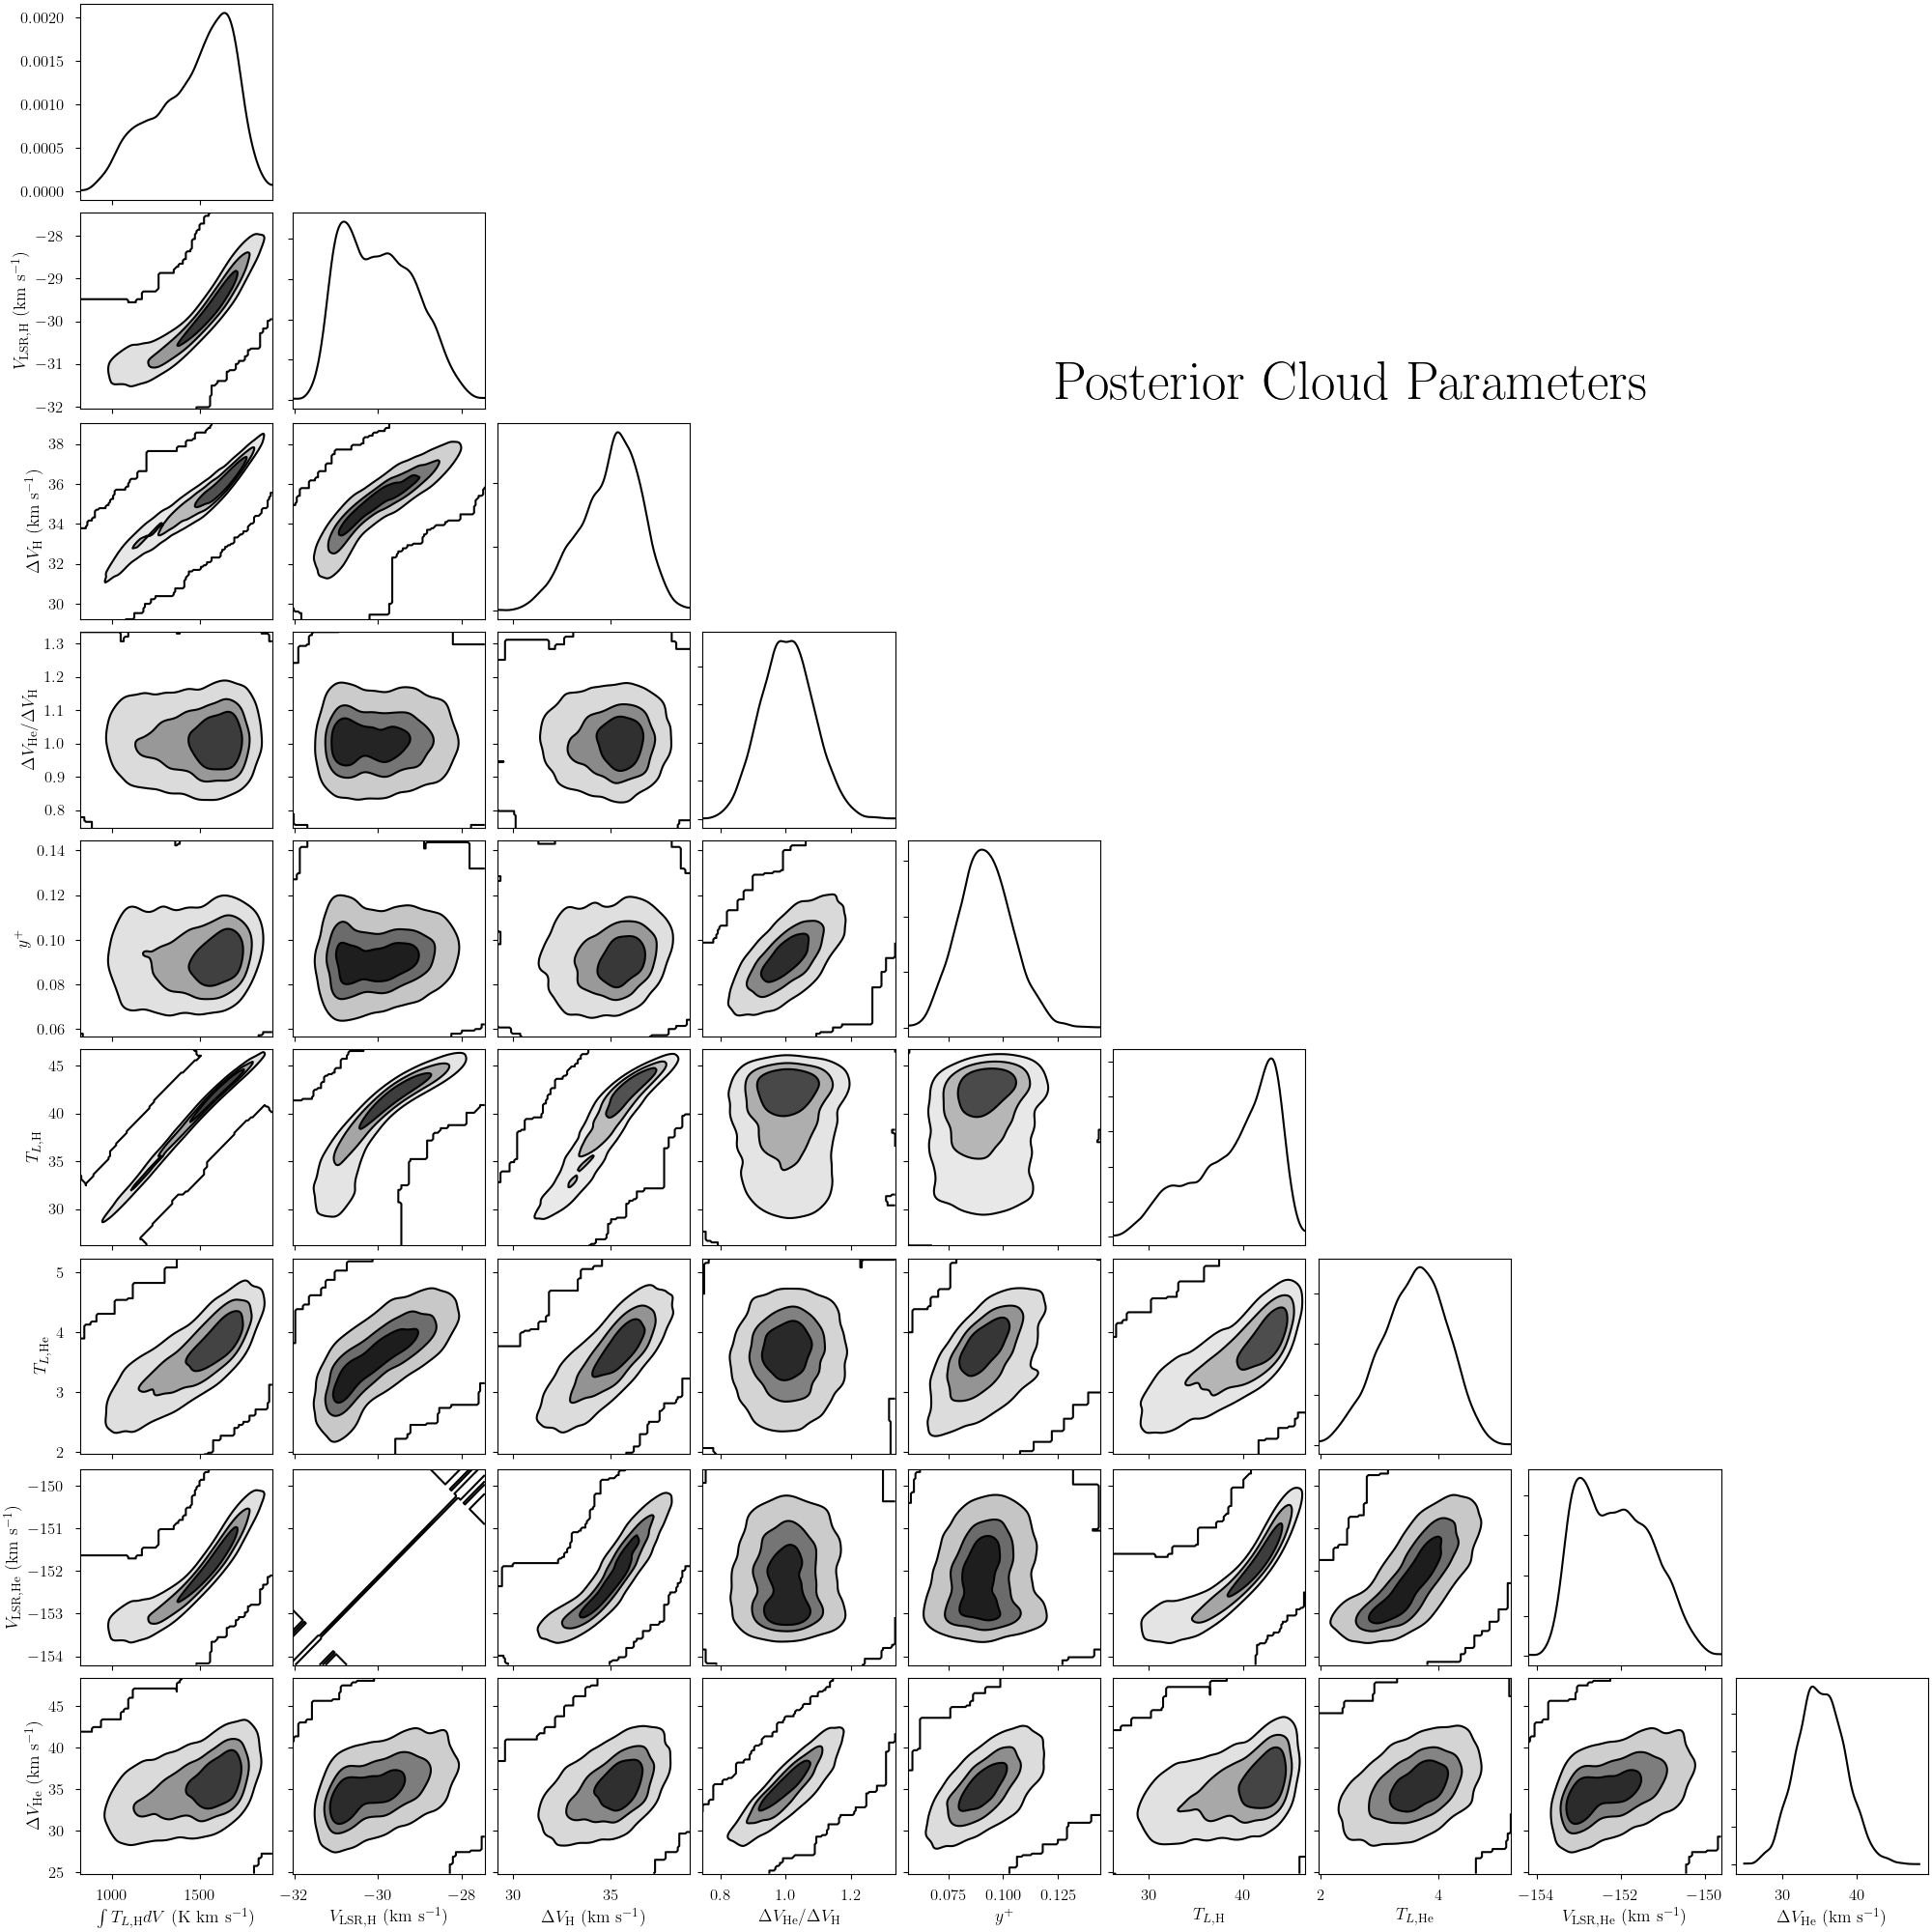

In [21]:
var_names = [var_name for var_name in model.deterministics if var_name not in ["rms_observation"]]
plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names, # var_names to plot
    "Posterior Cloud Parameters", # plot label
    f"{figdir}/pair_posterior_cloud_params_0.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
Image(f"{figdir}/pair_posterior_cloud_params_0.{ext}")

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [22]:
point_stats = az.summary(model.trace.solution_0, var_names=model.deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

"""
    "H_area": [1500.0, 1000.0, 1250.0],
    "H_center": [-30.0, 5.0, 25.0],
    "H_fwhm": [35.0, 50.0, 20.0],
    "He_H_fwhm_ratio": [1.0, 0.8, 1.25],
    "yplus": [0.1, 0.05, 0.15],
    "rms_observation": noise,
    "observation_baseline_norm": [0.0, -0.05, 0.01], # normalized baseline coefficients
"""

BIC: 847.4775074634551


,mean,sd,hdi_16%,hdi_84%
H_area[0],1464.668,218.942,1310.587,1736.340
H_area[1],1081.918,194.005,871.106,1143.545
H_area[2],1241.859,67.769,1188.566,1319.538
H_center[0],-29.979,0.852,-31.102,-29.315
H_center[1],4.397,6.333,-0.648,12.517
H_center[2],25.029,0.111,24.899,25.117
H_fwhm[0],34.964,1.536,33.765,36.769
H_fwhm[1],51.114,6.371,42.904,55.580
H_fwhm[2],20.080,0.419,19.716,20.542
He_H_fwhm_ratio[0],1.006,0.081,0.917,1.078


'\n    "H_area": [1500.0, 1000.0, 1250.0],\n    "H_center": [-30.0, 5.0, 25.0],\n    "H_fwhm": [35.0, 50.0, 20.0],\n    "He_H_fwhm_ratio": [1.0, 0.8, 1.25],\n    "yplus": [0.1, 0.05, 0.15],\n    "rms_observation": noise,\n    "observation_baseline_norm": [0.0, -0.05, 0.01], # normalized baseline coefficients\n'